In [1]:
import numpy as np 
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
import cv2

# from tensorflow.python.keras.applications.vgg16 import VGG16, preprocess_input
# from tensorflow.python.keras.applications.resnet import ResNet50, preprocess_input 
from tensorflow.python.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input 
# from tensorflow.python.keras.applications.efficientnet import EfficientNetB6, preprocess_input 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input

### Define the folder paths

In [2]:
base_dir = "/kaggle/input/knee-osteoarthritis-dataset-with-severity"

train_dir = os.path.join(base_dir,'train')
val_dir = os.path.join(base_dir,'val')
test_dir = os.path.join(base_dir, 'test')

### Let us plot some sample images from each of the classes

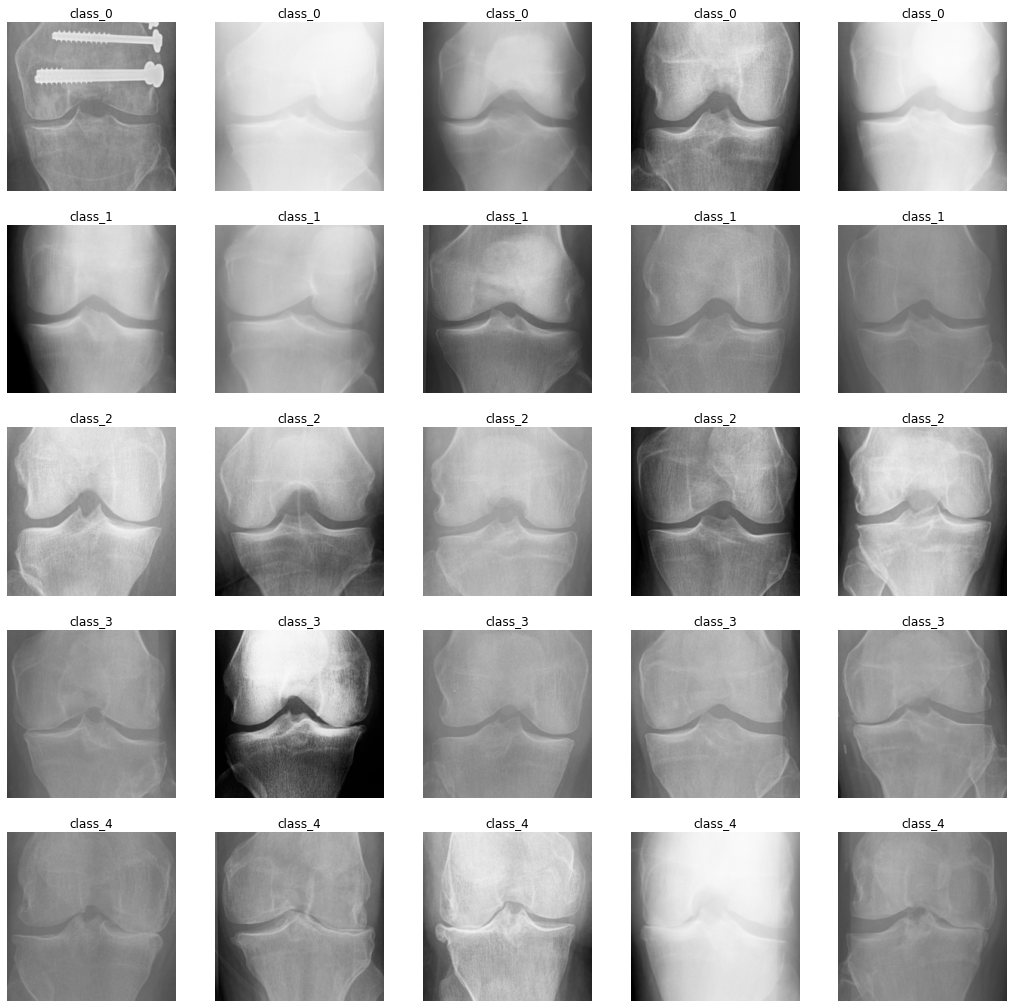

In [3]:
fig, ax = plt.subplots(5,5, figsize=(18,18))

for class_id in range(5):
    folder = os.path.join(train_dir,str(class_id))
    os.chdir(folder)
    samples = random.sample(os.listdir(folder), 5)
    
    for col in range(5):
        image = cv2.imread(samples[col])
        ax[class_id, col].imshow(image)
        ax[class_id, col].set_title("class_" + str(class_id))
        ax[class_id, col].set_axis_off()
    
plt.show()

### Let us check the distribution of the various classes for train, test and validation datasets

In [4]:
def show_distribution(folder):
    
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_directory(folder)

    counter = Counter(generator.classes)                          
    total_images = sum(counter.values())
    distribution = [(class_id,round(num_images / total_images * 100,2)) for class_id, num_images in counter.items()]

    for class_id, percentage in distribution:
        print(class_id, percentage)


In [5]:
print("The distribution for the training data is :\n")
show_distribution(train_dir)

The distribution for the training data is :

Found 5778 images belonging to 5 classes.
0 39.56
1 18.1
2 26.24
3 13.1
4 2.99


In [6]:
print("The distribution for the validation data is :\n")
show_distribution(val_dir)

The distribution for the validation data is :

Found 826 images belonging to 5 classes.
0 39.71
1 18.52
2 25.67
3 12.83
4 3.27


In [7]:
print("The distribution for the test data is :\n")
show_distribution(test_dir)

The distribution for the test data is :

Found 1656 images belonging to 5 classes.
0 38.59
1 17.87
2 26.99
3 13.47
4 3.08


### Dealing with imbalanced classes

We can see that the distributions are not balanced. Hence we would need to use ways to work with imbalanced data while training the model. One option is to use **"class_weights"**

Let us calculate the appropriate class weights

In [8]:
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(train_dir)

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}   
print("\nThe class weights are : \n\n", class_weights)

Found 5778 images belonging to 5 classes.

The class weights are : 

 {0: 1.0, 1: 2.18546845124283, 2: 1.507915567282322, 3: 3.0198150594451785, 4: 13.213872832369942}


### Check the size of the images

In [9]:
folder = os.path.join(train_dir,'0')
os.chdir(folder)
samples = random.sample(os.listdir(folder), 5)

for filename in samples:
    image = cv2.imread(filename)
    print(image.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


We can see that the images are all (224 X 224). We will have to choose the Transfer Model accordingly

## Build the model

In [10]:
NUM_CLASSES = 5
IMAGE_SIZE=[224, 224]
BATCH_SIZE=32

In [11]:
# Create the Generators
train_val_generator = ImageDataGenerator(
                                        preprocessing_function=preprocess_input,    
                                        rotation_range=10,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode='nearest'
                                        )


# Train data generator
train_data = train_val_generator.flow_from_directory(train_dir, 
                                                    target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=True
                                                    )

# Validation data generator
val_data = train_val_generator.flow_from_directory(val_dir, 
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  shuffle=True
                                                  )

# Test data generator
test_generator  = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_generator.flow_from_directory(test_dir, 
                                               target_size=IMAGE_SIZE,
                                               batch_size=1,
                                               class_mode='categorical',
                                               color_mode='rgb',
                                               shuffle=False
                                               )

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.
Found 1656 images belonging to 5 classes.


#### Load the base model

In [12]:
base_model = MobileNetV2(input_shape=IMAGE_SIZE + [3],
                            include_top=False,
                            weights='imagenet',
                            pooling='avg'
                           )

for layer in base_model.layers:
    layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


#### Now add our own layer to classify each image into one of the possible classes

In [13]:
x_input = base_model.input

x = Dense(128,activation='relu')(base_model.output)
x = Dropout(0.2)(x)

output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(x_input, output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Train the model

I have tried providing class_weights but found that the model was quite unstable and was not giving good accuracy. Hence not using the class weights parameter

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

hist = model.fit(train_data,
                 validation_data=val_data,
                 epochs=50,
#                  class_weight=class_weights,
                 callbacks=[reduce_lr, early_stopping],
                 verbose=1)

Epoch 1/50
181/181 [==============================] - 125s 657ms/step - loss: 1.5053 - accuracy: 0.3820 - val_loss: 1.2454 - val_accuracy: 0.4504
Epoch 2/50
181/181 [==============================] - 88s 486ms/step - loss: 1.2434 - accuracy: 0.4618 - val_loss: 1.1887 - val_accuracy: 0.4758
Epoch 3/50
181/181 [==============================] - 88s 489ms/step - loss: 1.1938 - accuracy: 0.4750 - val_loss: 1.1814 - val_accuracy: 0.4903
Epoch 4/50
181/181 [==============================] - 87s 483ms/step - loss: 1.1955 - accuracy: 0.4974 - val_loss: 1.1773 - val_accuracy: 0.4891
Epoch 5/50
181/181 [==============================] - 82s 455ms/step - loss: 1.1770 - accuracy: 0.4985 - val_loss: 1.1665 - val_accuracy: 0.4831
Epoch 6/50
181/181 [==============================] - 83s 461ms/step - loss: 1.1675 - accuracy: 0.5036 - val_loss: 1.1623 - val_accuracy: 0.5157
Epoch 7/50
181/181 [==============================] - 83s 458ms/step - loss: 1.1964 - accuracy: 0.4885 - val_loss: 1.1553 - val_a

The training stopped as the Early Stopping callback was triggered. That's ok. This is a very tough dataset and even getting around 52-53% accuracy across 5 classes is decent, if not the best

### Evaluate the model

In [15]:
model.evaluate(test_data)

1656/1656 [==============================] - 15s 9ms/step - loss: 1.1174 - accuracy: 0.5229


[1.11741304397583, 0.522946834564209]

We got an accuracy of 52.3% on the test set. The model is not overfitting and is giving a decent results. Please suggest other ways to improve this further. Would be very happy to hear your thoughts.